# CLMS Water Bodies Analysis

- product documentation: https://land.copernicus.eu/en/products/water-bodies/water-bodies-global-v2-0-300m
- Values of the quality lawer:

|   Digital value |  Description        |
|----------------:|:--------------------|
|               0 | Sea                 |
|              71 | Very low occurence  |
|              72 | Low occurence       |
|              73 | Medium occurence    |
|              74 | High occurence      |
|              75 | Very high occurence |
|              76 | Permanent occurence |
|             251 | No data             |
|             252 | Cloud               |
|             255 | Not water           |
## Setup
### Imports

In [2]:
import os
from os.path import join
import glob
from tqdm import tqdm
from datetime import datetime
import tempfile

import boto3

# geoprocessing imports
import numpy as np
import pandas as pd
import geopandas as gpd

from rasterio.enums import Resampling
import rioxarray
from rioxarray.exceptions import NoDataInBounds
import xarray as xr
from rasterstats import zonal_stats

## Parameters

In [ ]:
# main path
data_folder = '../data'

# paths
aoi_path = join(data_folder, 'admin', 'adm2.geojson')
clms_path = join(data_folder, 'clms')


# start / end dates
start_date="2020-01-01"
end_date="2025-12-31"

# Water Bodies COG Catalog URL
wb_catalog_url = "https://s3.waw3-1.cloudferro.com/swift/v1/CatalogueCSV/bio-geophysical/water_bodies/wb_global_300m_monthly_v2/wb_global_300m_monthly_v2_cog.csv"

# configure S3 access
COPERNICUS_S3_ACCESS_KEY = os.environ["COPERNICUS_S3_ACCESS_KEY"]
COPERNICUS_S3_SECRET_KEY = os.environ["COPERNICUS_S3_SECRET_KEY"]

## Functions

In [16]:
# Functions

# Main Code
## Load AOI

In [17]:
aoi_gdf = gpd.read_file(aoi_path)

aoi_utm_crs = aoi_gdf.estimate_utm_crs()
aoi_buffer = aoi_gdf.to_crs(aoi_utm_crs).dissolve().buffer(1000).to_crs(4326)
aoi_geom = aoi_buffer.unary_union
minx, miny, maxx, maxy = aoi_buffer.bounds.values[0]

## Load Water Bodies catalog

In [18]:
# Load the Water Bodies COG catalog
catalog_df = pd.read_csv(wb_catalog_url, sep=";")
catalog_df = catalog_df[(catalog_df["content_date_start"]>=start_date) & (catalog_df["content_date_end"]<=end_date)]

len(catalog_df)

35

## Download available rasters

In [19]:
s3_resource = boto3.resource(
    's3',
    endpoint_url='https://eodata.dataspace.copernicus.eu',
    aws_access_key_id=COPERNICUS_S3_ACCESS_KEY,
    aws_secret_access_key=COPERNICUS_S3_SECRET_KEY,
    region_name='default'
)  # generated secrets

bucket = s3_resource.Bucket("eodata")

In [20]:
# create a temporary dir for downloads
temp_dir = tempfile.TemporaryDirectory()
print(f"Starting download in {temp_dir.name} ...")

for i, item in tqdm(catalog_df.iterrows()):
    _, _, _, product = item["s3_path"].split("/", 3)
    files = bucket.objects.filter(Prefix=product)

    if not list(files):
        raise FileNotFoundError(f"Could not find any files for {product}")
    for file in files:
        output_path = join(temp_dir.name, os.path.basename(file.key))
        if 'QUAL' in output_path and not os.path.exists(output_path):
            bucket.download_file(file.key, output_path)

Starting download in /var/folders/bh/lbyrbl_n4ts1gvgzm4wkw1x40000gq/T/tmp89t9b2uw ...


0it [00:00, ?it/s]

35it [01:31,  2.60s/it]


In [21]:
file_list = glob.glob(os.path.join(temp_dir.name, "*.tiff"))

for file in file_list:
    filename = os.path.basename(file)
    ds = rioxarray.open_rasterio(file, chunks=dict(x=512, y=512), masked=True)
    ds = ds.sel(x=slice(minx, maxx), y=slice(maxy, miny)) # work on a slice to limit memory usage

    # fix metadata
    ds = ds.rio.write_crs(4326)
    ds = ds.rio.write_nodata(251)

    # clip
    try:
        ds = ds.rio.clip(aoi_buffer.geometry.values)
    except NoDataInBounds:
        print(f"No data in bound for {filename}, skipping")
        continue

    # save the raster file
    output_path = join(clms_path, filename)
    ds.rio.to_raster(output_path[:-1], compress='deflate', predictor=2)

## Perform zonal stats

In [48]:
from rasterstats import zonal_stats

file_list = glob.glob(os.path.join(clms_path, "*.tif"))
file_list = sorted(file_list, key=lambda x: os.path.basename(x))

# define a model to reproject all the other rasters
df_list = []
for file in tqdm(file_list):
    date = datetime.strptime(os.path.basename(file)[17:25], '%Y%m%d')

    # open the raster and extract
    with rioxarray.open_rasterio(file) as da:
        # extract the band and rescale
        da = da.squeeze(dim='band').drop_vars('band').expand_dims(time=[date])
        da = xr.where((da >= 71)&(da <= 76), 1, 0).astype('float32') # filter on water values
        da = da.rio.write_crs(4326) # re-write crs
        
        # transform to surface
        da = da.rio.reproject(32638, nodata=np.nan) # re-project to local crs
        res = max(da.rio.resolution()) # calculate spatial resolution
        da = da*res**2/10_000 # convert to ha
        

        # generate the zonal stats
        stats_dict = zonal_stats(
            aoi_gdf.to_crs(da.rio.crs),
            da.data[0],
            stats=['sum', 'std'],
            affine=da.rio.transform(),
            nodata=np.nan
        )
        
        stats_df = pd.DataFrame(stats_dict)
        stats_df['month'] = date
        df_list.append(stats_df)

stats_df = pd.concat(df_list).join(aoi_gdf['district']).reset_index(drop=True)
stats_df = stats_df.sort_values(['month', 'district'])

100%|██████████| 53/53 [02:00<00:00,  2.28s/it]


In [50]:
# export
stats_df.to_csv(join(data_folder, 'indicators', 'waterextent.csv'))

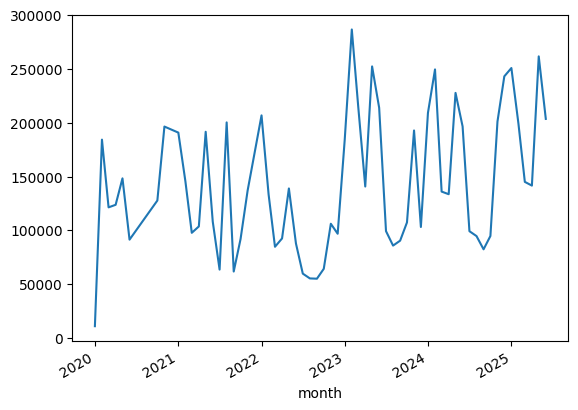

In [ ]:
stats_df[stats_df['district']=='Northern Buttes District'].set_index('month')['sum'].plot();

## Generate yearly aggregation

In [ ]:
clms_file_list = glob.glob(join(clms_path, '*.tif'))
years_list = ['2020', '2021', '2022', '2023', '2024', '2025']

for year in years_list:
    export_file_tiff = join(data_folder, 'aggregates', f'waterextent_{year}.tif')

    # if os.path.exists(export_file_tiff):
    #     continue

    file_list = sorted([f for f in clms_file_list if year in os.path.basename(f)])

    da_list = []
    # generate a rasters time series for the year
    for file in file_list:
        date = datetime.strptime(os.path.basename(file)[17:25], '%Y%m%d')
        with rioxarray.open_rasterio(file) as da:
            # extract the band and rescale
            da = da.squeeze(dim='band').drop_vars('band').expand_dims(time=[date])
            da = xr.where((da >= 71)&(da <= 76), 1, 0).astype('float32') # filter on water values
            da = da.rio.write_crs(4326) # re-write crs

            # for year 2020, we need to reproject all rasters on the same reference
            if year == '2020':
                if da.sum().values == 0: # skip empty files
                    continue
                if date == datetime(2020,1,1):
                    da_model = da
                else:
                    da = da.rio.reproject_match(da_model, nodata=np.nan, resampling=Resampling.bilinear)
        
            da_list.append(da)

    ds_concat = xr.concat(da_list, dim='time').to_dataset(name='waterextent')
    ds_concat = ds_concat.rio.set_crs(4326)
    
    # generate average tiff for the year
    (
        ds_concat['waterextent']
        .mean(dim='time', skipna=True)
        .rio.write_nodata(0)
        .rio.to_raster(export_file_tiff, compress='deflate', predictor=2)
    )

<HR>

# TESTS

In [ ]:
# Try to download the file in memory
import s3fs

fs = s3fs.S3FileSystem(
    key=COPERNICUS_S3_ACCESS_KEY,
    secret=COPERNICUS_S3_SECRET_KEY,
    client_kwargs={'endpoint_url': 'https://eodata.dataspace.copernicus.eu'}
)


for file in files:
    # Open directly from S3
    s3_path = f"EODATA/{file.key}"
    with fs.open(s3_path, 'rb') as f:
        da = rioxarray.open_rasterio(f, masked=True)

        aoi_geom = aoi_gdf.unary_union
        da = da.sel(x=slice(minx, maxx), y=slice(maxy, miny)) # work on a slice to limit memory usage

        da = da.rio.write_crs(4326)
        da = da.rio.write_nodata(251)

        # clip
        da = da.rio.clip([aoi_geom])

        # save the raster file
        da.rio.to_raster(output_path, compress='deflate', predictor=2)